<a href="https://colab.research.google.com/github/brunoleomenezes/MC-CD05/blob/main/02_LNCC_bruno_MC_CD05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Large Language Models - MC-CD05**
*Professor: Bruno Menezes e Daniel de Senna (LNCC)*

#Controle e inferência: parâmetros de geração (temperatura, top-p) e gerenciamento de contexto (KV cache, expected-attention, cache merging).

# Comparação Visual: Transformer vs BERT vs GPT-2

## 1. Transformer (bloco base comum)

- **Mesmo bloco** aparece em BERT e GPT.
- Aqui mostramos o **esqueleto**: entrada → embeddings → atenção → MLP → estados ocultos.

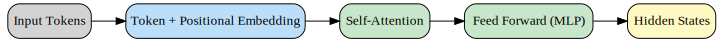

## 2. BERT (Encoder bidirecional)

- **Bidirecional**: cada token pode olhar para **todos** os outros.
- Focado em **entender** o texto (representações contextuais), não em gerar.

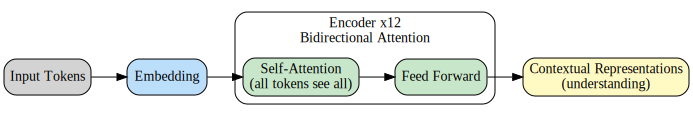

## 3. GPT-2 (Decoder causal)

- **Causal**: cada token olha só para o **passado**.
- Isso permite **geração autoregressiva**: prever o próximo token e repetir.

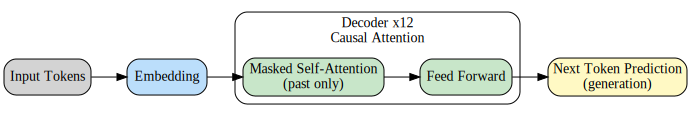

In [1]:
# ============================================================
# DIAGRAMAS DIDÁTICOS (Graphviz)
# Transformer "base"  →  BERT (Encoder)  →  GPT-2 (Decoder)
#
# Objetivo pedagógico:
# - Mostrar que BERT e GPT compartilham o mesmo "bloco Transformer"
# - O que muda é: máscara de atenção (bidirecional vs causal) e objetivo (entender vs gerar)
# ============================================================

# 1) Instalamos graphviz (biblioteca de diagramas) no Colab.
#    Obs.: Em alguns ambientes pode demorar um pouco na primeira vez.
!pip install -q graphviz

# 2) Importamos:
# - Digraph: cria grafos/diagramas
# - display/Markdown: para exibir título e subtítulos no notebook de forma bonita
from graphviz import Digraph
from IPython.display import display, Markdown

display(Markdown("# Comparação Visual: Transformer vs BERT vs GPT-2"))

# ------------------------------------------------------------
# Função utilitária: cria um "canvas" padrão para os diagramas
# Assim os 3 diagramas ficam com estilo consistente
# ------------------------------------------------------------
def make_base_graph(name: str) -> Digraph:
    g = Digraph(name, format="png")
    g.attr(rankdir="LR", size="10,4")  # LR = Left-to-Right (melhor para pipelines)
    g.attr("node", shape="rect", style="rounded,filled")  # caixas arredondadas e coloridas
    return g

# ============================================================
# 1) TRANSFORMER GENÉRICO (bloco comum)
# ============================================================
t = make_base_graph("Transformer")

# Nós (caixas) do fluxo:
# - Embeddings (azul): entrada em forma vetorial
# - Atenção/MLP (verde): transformação principal por camadas
# - Saída (amarelo): estados ocultos (representações internas)
t.node("t_in",  "Input Tokens")
t.node("t_emb", "Token + Positional Embedding", fillcolor="#BBDEFB")
t.node("t_attn","Self-Attention",              fillcolor="#C8E6C9")
t.node("t_ffn", "Feed Forward (MLP)",          fillcolor="#C8E6C9")
t.node("t_out", "Hidden States",               fillcolor="#FFF9C4")

# Conectamos as caixas na ordem do fluxo
t.edges([
    ("t_in", "t_emb"),
    ("t_emb", "t_attn"),
    ("t_attn", "t_ffn"),
    ("t_ffn", "t_out"),
])

display(Markdown("## 1. Transformer (bloco base comum)"))
display(Markdown(
    "- **Mesmo bloco** aparece em BERT e GPT.\n"
    "- Aqui mostramos o **esqueleto**: entrada → embeddings → atenção → MLP → estados ocultos."
))
display(t)

# ============================================================
# 2) BERT (ENCODER com atenção bidirecional)
# ============================================================
b = make_base_graph("BERT")

b.node("b_in",  "Input Tokens")
b.node("b_emb", "Embedding", fillcolor="#BBDEFB")

# Subgrafo (cluster) só para desenhar o "miolo" em uma caixa agrupada
# A ideia é comunicar: "Encoder repetido N vezes"
with b.subgraph(name="cluster_enc") as c:
    c.attr(label="Encoder x12\nBidirectional Attention", style="rounded")
    c.node("b_attn", "Self-Attention\n(all tokens see all)", fillcolor="#C8E6C9")
    c.node("b_ffn",  "Feed Forward",                        fillcolor="#C8E6C9")

# Saída típica do BERT: representações contextuais
# (ótimo para tarefas de compreensão/classificação/extração)
b.node("b_out", "Contextual Representations\n(understanding)", fillcolor="#FFF9C4")

b.edges([
    ("b_in",  "b_emb"),
    ("b_emb", "b_attn"),
    ("b_attn","b_ffn"),
    ("b_ffn", "b_out"),
])

display(Markdown("## 2. BERT (Encoder bidirecional)"))
display(Markdown(
    "- **Bidirecional**: cada token pode olhar para **todos** os outros.\n"
    "- Focado em **entender** o texto (representações contextuais), não em gerar."
))
display(b)

# ============================================================
# 3) GPT-2 (DECODER com atenção causal/mascarada)
# ============================================================
g = make_base_graph("GPT2")

g.node("g_in",  "Input Tokens")
g.node("g_emb", "Embedding", fillcolor="#BBDEFB")

# No GPT (decoder causal), há uma máscara:
# cada token só pode olhar para o passado (tokens anteriores).
# Isso torna possível gerar token a token de forma autoregressiva.
with g.subgraph(name="cluster_dec") as c:
    c.attr(label="Decoder x12\nCausal Attention", style="rounded")
    c.node("g_attn", "Masked Self-Attention\n(past only)", fillcolor="#C8E6C9")
    c.node("g_ffn",  "Feed Forward",                     fillcolor="#C8E6C9")

# Saída típica do GPT: predição do próximo token (base da geração)
g.node("g_out", "Next Token Prediction\n(generation)", fillcolor="#FFF9C4")

g.edges([
    ("g_in",  "g_emb"),
    ("g_emb", "g_attn"),
    ("g_attn","g_ffn"),
    ("g_ffn", "g_out"),
])

display(Markdown("## 3. GPT-2 (Decoder causal)"))
display(Markdown(
    "- **Causal**: cada token olha só para o **passado**.\n"
    "- Isso permite **geração autoregressiva**: prever o próximo token e repetir."
))
display(g)

In [2]:
# ============================================================
# SETUP DO AMBIENTE (Colab)
# Instalação de dependências + imports
#
# Objetivo:
# - Garantir que temos as bibliotecas necessárias para:
#   (1) carregar modelos Hugging Face (transformers)
#   (2) inspecionar arquitetura e nº de parâmetros (torchinfo)
#   (3) imprimir output bonito no notebook (rich)
# ============================================================

# 1) Instala bibliotecas (normalmente basta rodar 1 vez por sessão Colab)
# -q = "quiet": reduz o spam de logs
!pip install -q rich torchinfo transformers

# 2) Imports principais
import torch

# Rich: prints mais legíveis no notebook (cores, caixas, etc.)
from rich import print
from rich.panel import Panel
from rich.syntax import Syntax

# Torchinfo: resumo estruturado da arquitetura (camadas, shapes, params)
from torchinfo import summary

# Display/Markdown: títulos e texto formatado no notebook
from IPython.display import display, Markdown

# Transformers: carregamento de modelos/tokenizers via Hugging Face Hub
# - AutoTokenizer: escolhe o tokenizador correto automaticamente
# - AutoModelForCausalLM: modelos geradores (tipo GPT) → prevê próximo token
# - AutoModelForMaskedLM: modelos de "mask filling" (tipo BERT) → prevê token mascarado
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoModelForMaskedLM,
)

# 3) (Opcional, mas útil) Checagem rápida de hardware
device = "cuda" if torch.cuda.is_available() else "cpu"
display(Markdown(f"**Device detectado:** `{device}`"))
if device == "cuda":
    display(Markdown(f"**GPU:** `{torch.cuda.get_device_name(0)}`"))

**Device detectado:** `cuda`

**GPU:** `Tesla T4`

In [3]:
# ============================================================
# CARREGAMENTO DE MODELOS + DEVICE (GPT-2 e BERT)
#
# Objetivo pedagógico:
# - Ter 2 modelos com "papéis" diferentes para comparar:
#   (1) GPT-2  -> modelo CAUSAL (gera texto prevendo o próximo token)
#   (2) BERT   -> modelo MASKED (preenche tokens mascarados; não é gerador autoregressivo)
#
# Por que isso existe no notebook?
# - Para evitar NameError: precisamos criar gpt_model / bert_model antes de usar depois.
# - Para garantir que tudo roda no mesmo device (CPU ou GPU).
# ============================================================

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForMaskedLM

# 1) Detecta o device disponível
# - cuda = GPU NVIDIA (bem mais rápido)
# - cpu  = fallback (mais lento, mas roda em qualquer lugar)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Device detectado: {device}")
if device.type == "cuda":
    print(f"[INFO] GPU: {torch.cuda.get_device_name(0)}")

# ------------------------------------------------------------
# 2) GPT-2 (modelo causal → geração de texto)
# ------------------------------------------------------------
gpt_name = "gpt2"

# Tokenizer: texto <-> tokens
gpt_tokenizer = AutoTokenizer.from_pretrained(gpt_name)

# Modelo: CausalLM (prevê próximo token e suporta model.generate)
gpt_model = AutoModelForCausalLM.from_pretrained(gpt_name).to(device)

# Modo avaliação:
# - desativa dropout e outras fontes de aleatoriedade do treino
# - ideal para inferência (resultados mais estáveis)
gpt_model.eval()

print(f"[OK] GPT-2 carregado: {gpt_name}")

# ------------------------------------------------------------
# 3) BERT (modelo masked → "fill-mask", compreensão)
# ------------------------------------------------------------
bert_name = "bert-base-uncased"

bert_tokenizer = AutoTokenizer.from_pretrained(bert_name)

# BERT não é CausalLM; o head correto para a tarefa clássica é MaskedLM
# (prever tokens ocultos em posições [MASK])
bert_model = AutoModelForMaskedLM.from_pretrained(bert_name).to(device)
bert_model.eval()

print(f"[OK] BERT carregado: {bert_name}")

# (Opcional) Reforço didático curto:
print("\n[Resumo]")
print("- GPT-2: geração autoregressiva (próximo token) → bom para text generation")
print("- BERT : predição de token mascarado (fill-mask) → bom para compreensão/extração")

[INFO] Device detectado: cuda

[INFO] GPU: Tesla T4

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


[OK] GPT-2 carregado: gpt2

Loading weights:   0%|          | 0/202 [00:00<?, ?it/s]

BertForMaskedLM LOAD REPORT from: bert-base-uncased
Key                         | Status     |  | 
----------------------------+------------+--+-
cls.seq_relationship.bias   | UNEXPECTED |  | 
cls.seq_relationship.weight | UNEXPECTED |  | 
bert.pooler.dense.weight    | UNEXPECTED |  | 
bert.pooler.dense.bias      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


[OK] BERT carregado: bert-base-uncased

[Resumo]

- GPT-2: geração autoregressiva (próximo token) → bom para text generation

- BERT : predição de token mascarado (fill-mask) → bom para compreensão/extração

In [4]:
# ============================================================
# INSPEÇÃO DE ARQUITETURA: GPT-2 vs BERT
#
# Objetivo pedagógico:
# - "Abrir a caixa-preta" e ver como o modelo é organizado em módulos
# - Conectar os nomes vistos no diagrama (embeddings, atenção, MLP) com PyTorch
# - Usar torchinfo.summary para ter:
#   * shapes das tensões
#   * nº de parâmetros
#   * profundidade (quantas camadas)
# ============================================================

from IPython.display import display, Markdown
from rich.panel import Panel
from rich.syntax import Syntax
from torchinfo import summary
import torch

# ------------------------------------------------------------
# 1) Título no notebook
# ------------------------------------------------------------
display(Markdown("# Arquitetura GPT-2 e BERT — Visão Geral"))

# ------------------------------------------------------------
# 2) Visualização textual do GPT-2 (print do módulo PyTorch)
# ------------------------------------------------------------
print(Panel.fit("ARQUITETURA GPT-2 — VISÃO GERAL", border_style="cyan"))

# `str(gpt_model)` imprime a árvore de módulos: embeddings, blocos, atenção, MLP, etc.
# Isso ajuda a ver "o que existe" dentro do modelo.
syntax = Syntax(str(gpt_model), "python", theme="monokai", line_numbers=False)
print(syntax)

# ------------------------------------------------------------
# 3) Config do BERT (hiperparâmetros do modelo)
# ------------------------------------------------------------
print(Panel.fit("BERT — ENCODER BIDIRECIONAL (CONFIG)", border_style="green"))

# `bert_model.config` é um objeto com informações como:
# - número de camadas, heads, dimensão hidden, vocab size, etc.
print(bert_model.config)

# ------------------------------------------------------------
# 4) Torchinfo: resumo estruturado (shapes + params)
#
# Vamos criar uma entrada "dummy" (falsa) apenas para o summary
# (não é para "fazer a tarefa"; é só para o modelo rodar um forward)
# ------------------------------------------------------------
seq_len = 128
batch_size = 1

# input_ids: ids de tokens (inteiros) no intervalo [0, vocab_size)
dummy_input_ids = torch.zeros((batch_size, seq_len), dtype=torch.long, device=device)

# attention_mask: 1 para tokens válidos, 0 para padding
# Aqui colocamos tudo 1 (sem padding), que é o caso mais simples.
dummy_attention_mask = torch.ones((batch_size, seq_len), dtype=torch.long, device=device)

# token_type_ids: usado em BERT para "segmento A/B" (ex.: pergunta/resposta).
# Muitos casos usam tudo zero.
dummy_token_type_ids = torch.zeros((batch_size, seq_len), dtype=torch.long, device=device)

print(Panel.fit("TORCHINFO — BERT (MaskedLM head)", border_style="green"))
summary(
    bert_model,
    input_data={
        "input_ids": dummy_input_ids,
        "attention_mask": dummy_attention_mask,
        "token_type_ids": dummy_token_type_ids,
    },
    device=str(device),
)

print(Panel.fit("TORCHINFO — GPT-2 (CausalLM)", border_style="cyan"))
summary(
    gpt_model,
    input_data={"input_ids": dummy_input_ids},
    device=str(device),
)

# Arquitetura GPT-2 e BERT — Visão Geral

╭─────────────────────────────────╮
│ ARQUITETURA GPT-2 — VISÃO GERAL │
╰─────────────────────────────────╯

GPT2LMHeadModel(                                                                                                   
  (transformer): GPT2Model(                                                                                        
    (wte): Embedding(50257, 768)                                                                                   
    (wpe): Embedding(1024, 768)                                                                                    
    (drop): Dropout(p=0.1, inplace=False)                                                                          
    (h): ModuleList(                                                                                               
      (0-11): 12 x GPT2Block(                                                                                      
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)                                              
        (attn): GPT2Attention(                                                                                     
          (c_attn): Conv1D(nf=2304, nx=768)                                                                        
          (c_proj): Conv1D(nf=768, nx=768)                                                                         
          (attn_dropout): Dropout(p=0.1, inplace=False)                                                            
          (resid_dropout): Dropout(p=0.1, inplace=False)                                                           
        )                                                                                                          
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)                                              
        (mlp): GPT2MLP(                                                                                            
          (c_fc): Conv1D(nf=3072, nx=768)                                                                          
          (c_proj): Conv1D(nf=768, nx=3072)                                                                        
          (act): NewGELUActivation()                                                                               
          (dropout): Dropout(p=0.1, inplace=False)                                                                 
        )                                                                                                          
      )                                                                                                            
    )                                                                                                              
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)                                                  
  )                                                                                                                
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)                                               
)                                                                                                                  

╭──────────────────────────────────────╮
│ BERT — ENCODER BIDIRECIONAL (CONFIG) │
╰──────────────────────────────────────╯

BertConfig {
  "add_cross_attention": false,
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": null,
  "classifier_dropout": null,
  "dtype": "float32",
  "eos_token_id": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "tie_word_embeddings": true,
  "transformers_version": "5.0.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

╭──────────────────────────────────╮
│ TORCHINFO — BERT (MaskedLM head) │
╰──────────────────────────────────╯

╭──────────────────────────────╮
│ TORCHINFO — GPT-2 (CausalLM) │
╰──────────────────────────────╯

Layer (type:depth-idx)                             Output Shape              Param #
GPT2LMHeadModel                                    --                        --
├─GPT2Model: 1-1                                   --                        --
│    └─Embedding: 2-1                              [1, 128, 768]             38,597,376
│    └─Embedding: 2-2                              [1, 128, 768]             786,432
│    └─Dropout: 2-3                                [1, 128, 768]             --
│    └─ModuleList: 2-4                             --                        --
│    │    └─GPT2Block: 3-1                         [1, 128, 768]             7,087,872
│    │    └─GPT2Block: 3-2                         [1, 128, 768]             7,087,872
│    │    └─GPT2Block: 3-3                         [1, 128, 768]             7,087,872
│    │    └─GPT2Block: 3-4                         [1, 128, 768]             7,087,872
│    │    └─GPT2Block: 3-5                         [1, 128, 768]          

#
# INFERÊNCIA (GERAÇÃO) COM MODELO CAUSAL (GPT-2)
#

In [5]:
# ============================================================
# Controle: temperatura, top-p e KV cache
# ============================================================

import time # Import the time module

In [6]:
# -----------------------------
# CÉLULA 25 — Carregar modelo causal (GPT-2)
# -----------------------------
gpt_name = "gpt2"                                              # Modelo causal leve e didático
gpt_tokenizer = AutoTokenizer.from_pretrained(gpt_name)        # Tokenizer BPE do GPT-2
gpt_model = AutoModelForCausalLM.from_pretrained(gpt_name)     # Modelo causal para geração
gpt_model.to(device)                                           # Move para GPU/CPU
gpt_model.eval()                                               # Modo avaliação

print("\n[GPT] Modelo carregado:", gpt_name)

print("\n==============================")
print("[ARQUITETURA GPT-2 — VISÃO GERAL]")
print("==============================")
print(gpt_model)


Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


[GPT] Modelo carregado: gpt2

==============================

[ARQUITETURA GPT-2 — VISÃO GERAL]

==============================

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [7]:
# -----------------------------
# Carregar modelo causal (GPT-2)
# -----------------------------
# Objetivo: carregar um modelo "decoder-only" simples (GPT-2) para demonstrar geração.
# GPT-2 é um modelo CAUSAL: ele prevê o próximo token dado um prefixo.
# Isso é a base do mecanismo autoregressivo: gerar token a token.

gpt_name = "gpt2"  # checkpoint no Hugging Face Hub (leve e didático)

# 1) Tokenizer: converte texto <-> tokens (ids)
#    GPT-2 usa BPE, então ele quebra texto em subpalavras.
gpt_tokenizer = AutoTokenizer.from_pretrained(gpt_name)

# (Opcional) GPT-2 não define pad_token por padrão.
# Isso pode causar warnings em algumas chamadas de generate com padding.
# Aqui setamos pad_token como eos_token, que é uma prática comum para GPT-2.
if gpt_tokenizer.pad_token is None:
    gpt_tokenizer.pad_token = gpt_tokenizer.eos_token

# 2) Modelo: AutoModelForCausalLM = modelo com "head" de linguagem causal,
#    ou seja, pronto para model.generate() e predição do próximo token.
gpt_model = AutoModelForCausalLM.from_pretrained(gpt_name).to(device)

# 3) Modo avaliação:
#    - desativa dropout
#    - deixa a inferência mais estável/reprodutível
gpt_model.eval()

print(f"\n[GPT] Modelo carregado: {gpt_name}")
print(f"[GPT] Device: {next(gpt_model.parameters()).device}")

print("\n==============================")
print("[ARQUITETURA GPT-2 — VISÃO GERAL]")
print("==============================")

# 4) Imprime a "árvore" de módulos do PyTorch (embeddings, blocos, atenção, MLP etc.)
print(gpt_model)

# (Dica opcional para a aula)
# Para inferência, você pode usar:
# with torch.inference_mode():
#     ... model.generate(...)
# Isso reduz overhead e pode ser um pouco mais rápido.

Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


[GPT] Modelo carregado: gpt2

[GPT] Device: cuda:0

==============================

[ARQUITETURA GPT-2 — VISÃO GERAL]

==============================

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [8]:
# -----------------------------
# Função de geração controlada (temperatura, top-p, KV cache)
# -----------------------------
# Objetivo pedagógico:
# - Encapsular uma chamada de geração (model.generate)
# - Permitir comparar rapidamente diferentes estratégias de decoding:
#   * temperature (aleatoriedade)
#   * top-p (nucleus sampling)
#   * use_cache (KV cache: acelera geração em prompts longos)
def generate_text(
    prompt: str,
    max_new_tokens: int = 80,
    temperature: float = 1.0,
    top_p: float = 1.0,
    use_cache: bool = True,
    do_sample: bool = True,
):
    # 1) Tokenização: transforma texto em tensores (input_ids, attention_mask)
    #    e envia os tensores para o mesmo device do modelo (CPU/GPU).
    inputs = gpt_tokenizer(prompt, return_tensors="pt").to(device)

    # 2) Inferência: não precisamos de gradientes (não estamos treinando).
    #    inference_mode é uma opção eficiente para esse caso.
    with torch.inference_mode():
        output_ids = gpt_model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,   # número de tokens *novos* além do prompt
            do_sample=do_sample,             # True = sampling; False = greedy/beam (mais determinístico)
            temperature=temperature,         # >1.0 mais diverso; <1.0 mais conservador
            top_p=top_p,                     # nucleus sampling (massa de probabilidade)
            use_cache=use_cache,             # KV cache: acelera geração passo-a-passo
            pad_token_id=gpt_tokenizer.eos_token_id,  # evita warnings em modelos sem pad_token
        )

    # 3) Decodificação: transforma ids de tokens de volta em texto.
    #    output_ids[0] porque o batch aqui tem tamanho 1.
    text = gpt_tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return text

In [9]:
# -----------------------------
# Teste base de geração (sanity check)
# -----------------------------
# Objetivo pedagógico:
# - Confirmar que o modelo está carregado e conseguindo gerar texto
# - Estabelecer uma "linha de base" antes de comparar temperatura/top-p/caching

prompt = "Transformers are models that"

print("\n[PROMPT]")
print(prompt)

print("\n[GERAÇÃO BASE] (temperature=0.7, top_p=0.9)")
print(generate_text(prompt, temperature=0.7, top_p=0.9))

# (Opcional) Se quiser mostrar variabilidade do sampling:
print("\n[GERAÇÃO BASE — segunda execução] (pode mudar por causa do sampling)")
print(generate_text(prompt, temperature=0.7, top_p=0.9))

[PROMPT]

Transformers are models that

[GERAÇÃO BASE] (temperature=0.7, top_p=0.9)

Transformers are models that can be used to modify the appearance of objects.

To create a new model, you must use the following syntax:

import { model } from '../models/model';

Note that you must use the model class in the constructor to add it to your model. You can also use the model class
in the constructor to create a new object that is used to modify the appearance

[GERAÇÃO BASE — segunda execução] (pode mudar por causa do sampling)

Transformers are models that are used to create and manipulate objects. These models are often referred to as 
"models" by the user. They are often used to create a 3D model of a character.

A character is a piece of information that is attached to a character. Characters can be created using any other 
character.

A character's name can be used to refer to a character.

The names

In [10]:
# -----------------------------
# Experimento: efeito da TEMPERATURA
# -----------------------------
# Intuição:
# - temperatura baixa  -> distribuição mais "concentrada" -> respostas mais previsíveis/estáveis
# - temperatura alta   -> distribuição mais "espalhada"   -> respostas mais diversas (e às vezes mais erráticas)
#
# Mantemos top_p fixo para isolar o efeito da temperatura.
temps = [0.2, 0.7, 1.0]
top_p_fixed = 0.9

for temp in temps:
    print("\n" + "=" * 40)
    print(f"[EXPERIMENTO] TEMPERATURA = {temp} (top_p={top_p_fixed})")
    print("=" * 40)

    # Rodamos 2 amostras para ver variabilidade (sampling).
    for i in range(2):
        print(f"\n[Amostra {i+1}]")
        print(generate_text(prompt, temperature=temp, top_p=top_p_fixed))

========================================

[EXPERIMENTO] TEMPERATURA = 0.2 (top_p=0.9)

========================================

[Amostra 1]

Transformers are models that are used to represent the physical properties of objects. They are also used to 
represent the properties of objects in the world.

The following table shows the properties of objects in the world.

Property Name Description Description 1 The object is a cube. 2 The object is a cube with a radius of 1. 3 The 
object is a cube with a radius of 1. 4 The object is a

[Amostra 2]

Transformers are models that are used to represent the physical properties of objects.

The following table lists the properties of the following objects:

The following table lists the properties of the following objects:

The following table lists the properties of the following objects:

The following table lists the properties of the following objects:

The following table lists the properties of the following objects:

The following table

========================================

[EXPERIMENTO] TEMPERATURA = 0.7 (top_p=0.9)

========================================

[Amostra 1]

Transformers are models that can be used in conjunction with the default geometry to create the geometry for a 
given shape.

For example, suppose that you have a circle with a square shape. The shape you are looking at is the shape of the 
circle, and the radius is the radius of the circle. You can also use the radius function to generate the shapes you
want.

We will define a geometry using the

[Amostra 2]

Transformers are models that can be created by using the following commands:

#!/bin/bash $ python3 $ python3.3 -u

Or by using the following command:

$ python3 $ python3.3 -u

The command you use to create an existing object is:

$ python3 create-object -u

The -u option lets you specify the

========================================

[EXPERIMENTO] TEMPERATURA = 1.0 (top_p=0.9)

========================================

[Amostra 1]

Transformers are models that are capable of moving with a single, powerful arm. They can do much more than just 
lift their arms. They can also drive. They can accelerate and manipulate objects.

That means that we can do far more with them. With some technology, we can have them act as vehicles for us. The 
next time someone tries to drive a car from its position in front of the car, or

[Amostra 2]

Transformers are models that are used for rendering the virtual objects in OpenGL. The models that can be applied 
are defined using the "glTexCoordXComposer" attribute. OpenGL is the GL coordinate system used to represent all the
physical objects on the screen. The actual size of the object on the screen depends on how far away from the object
you wish to render. For most applications, the object you're rendering

In [11]:
# -----------------------------
# Experimento: efeito do TOP-P (Nucleus Sampling)
# -----------------------------
# Intuição:
# - top_p pequeno (ex.: 0.3)  -> só considera um conjunto bem pequeno de tokens prováveis
#                              -> texto mais conservador/repetitivo
# - top_p grande  (ex.: 0.9)  -> considera mais candidatos
#                              -> mais diversidade (e mais risco de "viajar")
#
# Mantemos temperatura fixa para isolar o efeito do top_p.
top_ps = [0.3, 0.6, 0.9]
temp_fixed = 0.7

for p in top_ps:
    print("\n" + "=" * 40)
    print(f"[EXPERIMENTO] TOP-P = {p} (temperature={temp_fixed})")
    print("=" * 40)

    # Rodamos mais de uma vez para enxergar variabilidade
    for i in range(2):
        print(f"\n[Amostra {i+1}]")
        print(generate_text(prompt, temperature=temp_fixed, top_p=p))

========================================

[EXPERIMENTO] TOP-P = 0.3 (temperature=0.7)

========================================

[Amostra 1]

Transformers are models that are not part of the game.

The following is a list of all the models that are not part of the game.

A model that is not part of the game

A model that is not part of the game

A model that is not part of the game

A model that is not part of the game

A model that is not part of the

[Amostra 2]

Transformers are models that are used to represent the physical properties of objects. They are also used to 
represent the properties of objects in the world.

The following example shows how to use the following model to represent the properties of objects in the world.

import math import matplotlib.pyplot as plt import matplotlib.pyplot.pltplot as plt.plt.plt

========================================

[EXPERIMENTO] TOP-P = 0.6 (temperature=0.7)

========================================

[Amostra 1]

Transformers are models that are based on the actual physical world of the character. They are based on the 
physical world of the character, and are not necessarily the same as the real world.

In order to understand the concept of the character, you need to understand how the world works.

The world is a collection of things. The world is a collection of things that are not in common, and that are

[Amostra 2]

Transformers are models that are designed to be used in a variety of different ways. For example, the model is 
designed to be used in a variety of different ways, such as as a car or a house. The model can be used in a variety
of different ways, such as as a vehicle, a house, or a building.

The model can be used in a variety of different ways, such as as

========================================

[EXPERIMENTO] TOP-P = 0.9 (temperature=0.7)

========================================

[Amostra 1]

Transformers are models that can be customized to fit the specific needs of your project. In our case, we wanted to
have a way to make our existing sprites look like they were made by the same person. To do that, we built an 
animation system using the Unity 3D engine.

The animation system is very simple. It's a collection of sprites that can be animated in a single frame. In this 
case

[Amostra 2]

Transformers are models that are generated by the graphics processing unit (GPU). The graphics processing unit 
(GPU) is a small unit that has a fixed resolution and a fixed texture size. In order to have a good image quality, 
the graphics processing unit must have at least 4 texture units. The texture units are arranged in a set of four 
rows. Each row contains a vertex (the "x" coordinate). Each row contains

In [12]:
# -----------------------------
# KV cache: comparação de tempo (com e sem cache)
# -----------------------------
# Intuição:
# - Sem KV cache: a cada novo token gerado, o modelo "recalcula" atenção para toda a sequência.
# - Com KV cache: o modelo reaproveita K e V dos tokens passados, economizando compute.
#
# Importante:
# - Medição em Colab tem ruído. Fazemos warm-up e repetimos algumas vezes.

import time

prompt_kv = "Large language models rely on attention mechanisms"

def timed_generation(use_cache: bool, n_runs: int = 3) -> float:
    """Retorna o tempo médio (em segundos) de n_runs gerações."""
    times = []

    # Warm-up: reduz a chance da primeira medição ser um outlier
    _ = generate_text(
        prompt_kv,
        max_new_tokens=120,
        temperature=0.7,
        top_p=0.9,
        use_cache=use_cache,
    )

    for _ in range(n_runs):
        start = time.time()
        _ = generate_text(
            prompt_kv,
            max_new_tokens=120,
            temperature=0.7,
            top_p=0.9,
            use_cache=use_cache,
        )
        times.append(time.time() - start)

    return sum(times) / len(times)

t_cache = timed_generation(True, n_runs=3)
t_no_cache = timed_generation(False, n_runs=3)

print("\n[KV CACHE — TEMPO MÉDIO]")
print(f"Com cache : {t_cache:.4f} s")
print(f"Sem cache : {t_no_cache:.4f} s")

# Speedup (quanto mais rápido com cache)
if t_cache > 0:
    print(f"Speedup  : {t_no_cache / t_cache:.2f}×")

[KV CACHE — TEMPO MÉDIO]

Com cache : 2.2645 s

Sem cache : 1.2460 s

Speedup  : 0.55×

#
# PRÁTICA 1: INFERÊNCIA INTERATIVA (PROMPTS + VARIAÇÃO)
#

In [13]:
# -----------------------------
# Prompt direto vs "step by step" (demonstração didática)
# -----------------------------
# Ideia:
# - O prompt pode mudar o "modo" de resposta do modelo.
# - "Step by step" costuma induzir explicação em etapas (às vezes melhora a qualidade),
#   mas NÃO é garantia de acerto — especialmente em modelos pequenos.
#
# Aqui a meta é comparar:
# (1) resposta curta/direta
# (2) resposta explicada em etapas
# mantendo os mesmos hiperparâmetros de geração.

prompt_direct = "What is 27 + 58?"
prompt_step   = "Solve step by step: 27 + 58."

# Mantemos decoding constante para a comparação ser justa
TEMP = 0.7
TOP_P = 0.9

print("\n=== Direto (resposta curta) ===")
print(generate_text(
    prompt_direct,
    temperature=TEMP,
    top_p=TOP_P,
    max_new_tokens=40
))

print("\n=== Step by step (explicado em etapas) ===")
print(generate_text(
    prompt_step,
    temperature=TEMP,
    top_p=TOP_P,
    max_new_tokens=80
))

# (Opcional) Nota didática rápida para a turma:
# - Se o modelo errar 27+58, isso é um gancho para discutir:
#   "fluência" ≠ "correção".
# - Modelos maiores e/ou métodos como self-consistency costumam ajudar mais.

=== Direto (resposta curta) ===

What is 27 + 58?

This is the 27th of the month and the first month of the year.

Do you have a question about this question? Please send it to the question form below and I will

=== Step by step (explicado em etapas) ===

Solve step by step: 27 + 58.5% = 29.9%

The most common method of solving this puzzle is by using a series of steps, which are repeated over and over. As 
you progress, you can see how difficult it is to get all 27 steps, which are the same as the first 25.

A typical puzzle is this:

Step 1:

Step 2:

Step 3

In [14]:
# -----------------------------
# Variabilidade com temperatura mais alta (sampling)
# -----------------------------
# O que observar:
# - Com temperatura/top_p mais altos, a saída tende a variar mais entre execuções
# - A estrutura pode mudar (ordem dos passos, detalhes, exemplos), mesmo mantendo a mesma pergunta

N_SAMPLES = 3
TEMP = 0.9
TOP_P = 0.95
MAX_TOKENS = 80

print("\n[Experimento] Variabilidade com sampling mais 'solto'")
print(f"Config: temperature={TEMP}, top_p={TOP_P}, max_new_tokens={MAX_TOKENS}")

for i in range(N_SAMPLES):
    print(f"\n--- Amostra {i+1}/{N_SAMPLES} ---")

    # (Opcional) Seed para reprodutibilidade controlada:
    # Descomente se quiser que cada amostra seja sempre a mesma em cada execução do notebook.
    # torch.manual_seed(100 + i)

    print(generate_text(
        prompt_step,
        temperature=TEMP,
        top_p=TOP_P,
        max_new_tokens=MAX_TOKENS
    ))

[Experimento] Variabilidade com sampling mais 'solto'

Config: temperature=0.9, top_p=0.95, max_new_tokens=80

--- Amostra 1/3 ---

Solve step by step: 27 + 58.6 × 3.37 = 7 + 0.093 × 1.19 = 6

Step 1: 5 × 9 = 8 + 0.093 × 1.19 = 5

Step 2: 8 × 9 = 7 + 0.093 × 1.19 = 4

Step 3: 7 × 9 = 6 + 0.093 × 1.19 =

--- Amostra 2/3 ---

Solve step by step: 27 + 58.

This step includes:

25 – 35 (not in the 4/4 or 6/6 group),

50 – 75 (not in the 5/7 and 6/8 group),

75 – 85 (not in the 5/5 and 6/7 group),

90 – 95 (not in the 6/5 and 6/8 group),

--- Amostra 3/3 ---

Solve step by step: 27 + 58.5 + 30 + 61.5 - 30 + 57.5 + 31 + 63.5 - 34 + 62 + 33 + 67 + 37 + 64 + 35 + 70 + 37 + 67
+ 38 + 66 + 38 + 67 + 39 + 67 + 39 + 67 + 40 + 67 + 41 + 68 + 42 + 69 + 42 + 69 + 43 + 69 + 44 + 70 +

## Inferência Interativa: experimentação guiada com prompts e parâmetros de geração, explorando variação de temperatura, top-p e raciocínio via chain-of-thought.


In [15]:
# ============================================================
# SETUP —  Inferência Interativa
#
# Objetivo:
# - Instalar dependências mínimas
# - Importar bibliotecas
# - Detectar o device (GPU/CPU) para rodar inferência de forma eficiente
# ============================================================

# 1) Instalação (uma vez por sessão Colab)
# - transformers: carregar modelos/tokenizers do Hugging Face
# - torch: tensores e execução em GPU/CPU
# - numpy: utilidades numéricas (às vezes útil para análises simples)
!pip -q install transformers torch numpy

# 2) Imports
import time
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# 3) Device (GPU se disponível, senão CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Device detectado: {device}")

if device.type == "cuda":
    print(f"[INFO] GPU: {torch.cuda.get_device_name(0)}")

# Nota: este notebook é de INFERÊNCIA (não treino).
# Em células de geração, prefira usar:
#   with torch.inference_mode(): ...
# para reduzir overhead e deixar explícito que não há gradientes.

[INFO] Device detectado: cuda

[INFO] GPU: Tesla T4

In [16]:
# ============================================================
# CARREGAR MODELO CAUSAL (GPT-2)
#
# Objetivo:
# - Carregar um modelo "decoder-only" (causal) para geração autoregressiva
# - Preparar tokenizer + modelo no mesmo device (CPU/GPU)
# ============================================================

gpt_name = "gpt2"

# 1) Tokenizer: texto <-> tokens (ids inteiros)
tokenizer = AutoTokenizer.from_pretrained(gpt_name)

# GPT-2 normalmente não vem com pad_token definido.
# Para evitar warnings em generate (especialmente se houver padding),
# definimos pad_token = eos_token (prática comum em GPT-2).
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# 2) Modelo causal: pronto para prever próximo token e usar model.generate()
model = AutoModelForCausalLM.from_pretrained(gpt_name).to(device)

# 3) Modo avaliação: desativa dropout e estabiliza inferência
model.eval()

print(f"\n[OK] Modelo carregado: {gpt_name}")
print(f"[INFO] Device do modelo: {next(model.parameters()).device}")

# 4) Mostra a "árvore" de módulos (embeddings, blocos, atenção, MLP...)
print("\n[ARQUITETURA — VISÃO GERAL]")
print(model)

Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


[OK] Modelo carregado: gpt2

[INFO] Device do modelo: cuda:0

[ARQUITETURA — VISÃO GERAL]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [17]:
# ============================================================
# FUNÇÃO DE GERAÇÃO CONTROLADA (decoding)
# ============================================================
# O modelo sempre produz logits (probabilidades do próximo token).
# "Decoding" é como escolhemos o próximo token a partir dessas probabilidades.
#
# Parâmetros principais:
# - temperature: controla quão "aberta" fica a distribuição (diversidade)
# - top_p: nucleus sampling (considera só um conjunto de tokens que soma p de prob.)
# - do_sample: se False, vira greedy/beam e temperature/top_p podem perder efeito
# - use_cache: ativa KV cache (acelera geração em prompts longos)
def generate_text(
    prompt: str,
    temperature: float = 0.7,
    top_p: float = 0.9,
    max_new_tokens: int = 80,
    use_cache: bool = True,
    do_sample: bool = True,
):
    # 1) Tokeniza o prompt e envia para o mesmo device do modelo
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    # 2) Inferência (sem gradientes, sem treino)
    with torch.inference_mode():
        out_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=do_sample,
            temperature=temperature,
            top_p=top_p,
            use_cache=use_cache,
            pad_token_id=tokenizer.eos_token_id,  # evita warnings no GPT-2
        )

    # 3) Decodifica ids -> texto
    return tokenizer.decode(out_ids[0], skip_special_tokens=True)

In [18]:
# ============================================================
# TEMPERATURA (τ): controle de aleatoriedade
# ============================================================
print("\n" + "="*70)
print("VARIAÇÃO DE TEMPERATURA (τ)")
print("="*70)

# Prompt base (curto e neutro para facilitar comparação)
prompt = "Transformers are models that"

# Valores de temperatura para comparação
temps = [0.2, 0.7, 1.0]

# Guardamos as saídas em um dicionário (útil para comparar depois)
outputs_temp = {}

print("\nO que observar:")
print("- Coerência / fluência")
print("- Diversidade de palavras/ideias")
print("- Tendência a repetir padrões vs. inventar variações\n")

# (Opcional) mais de uma amostra por temperatura para evidenciar variabilidade
N_SAMPLES = 2

for t in temps:
    print("\n" + "-"*30)
    print(f"TEMPERATURA = {t}")
    print("-"*30)

    outputs_temp[t] = []

    for i in range(N_SAMPLES):
        text = generate_text(prompt, temperature=t, top_p=0.9, max_new_tokens=80, do_sample=True)
        outputs_temp[t].append(text)

        print(f"\n[Amostra {i+1}]")
        print(text)

print("\n" + "="*70)
print("EXPLICAÇÃO — RESUMO")
print("="*70)
print("""
- τ = 0.2 (baixa):
  Saída mais rígida e previsível. O modelo tende a escolher tokens muito prováveis.
  Distribuição efetiva fica mais concentrada → menos diversidade.

- τ = 0.7 (média):
  Bom equilíbrio: mantém coerência e ainda permite variações úteis.

- τ = 1.0 (alta):
  Mais diversidade e “criatividade”, mas aumenta o risco de deriva semântica/erros.

Conclusão:
Temperatura controla a “concentração” da distribuição de escolha do próximo token:
τ baixo concentra (mais determinístico); τ alto espalha (mais diverso).
""")

======================================================================

VARIAÇÃO DE TEMPERATURA (τ)

======================================================================

O que observar:

- Coerência / fluência

- Diversidade de palavras/ideias

- Tendência a repetir padrões vs. inventar variações

------------------------------

TEMPERATURA = 0.2

------------------------------

[Amostra 1]

Transformers are models that are used to represent the properties of objects.

The following example shows how to create a model that is used to represent the properties of objects.

public class Model { public static void main(String[] args) { Model.setProperty(new Model("name", "name")); } }

The following example shows how to create a model that is used to represent the properties

[Amostra 2]

Transformers are models that are used to represent the properties of objects.

The following example shows how to use the following properties to represent the properties of objects.

public class Object { public static void main(String[] args) { Object object = new Object(); Object object = new 
Object(); Object object = new Object(); Object object = new Object(); Object object = new Object(); Object object =
new Object();

------------------------------

TEMPERATURA = 0.7

------------------------------

[Amostra 1]

Transformers are models that can be used to represent objects in the game world. For example, the following is an 
example of a particle model that represents a player character:

// Example of particle model for a player character. // Use this as a model for the player character. // The 
following is an example of a particle model for a player character. // Use this as a model for the player 
character. // The

[Amostra 2]

Transformers are models that are created by the AI. It is the case that the AI is able to predict the direction and
speed of the player's movement by looking at the data in the data and calculating how long the player is going to 
be able to move.

The player can also calculate the speed of a vehicle by calculating the speed at which it will be moving.

To use this information in a game

------------------------------

TEMPERATURA = 1.0

------------------------------

[Amostra 1]

Transformers are models that can have a default value of null.

If you are a creator of an image or texture, that's usually not a problem. A non-default value will give you an 
error message if the object isn't initialized with the correct value.

If you're using a texture you could use the --no-initialize flag.

Example

use Wolf, Wolf.Color

[Amostra 2]

Transformers are models that are used for all interactions with objects. Objects are defined as a set of variables 
such as the name, the type of an object and the name of its value. This is the first part of our example.

var object = function(name, value) { console.log("name = " + name); }

The function is simply passed a list of variables, and returns the

======================================================================

EXPLICAÇÃO — RESUMO

======================================================================

- τ = 0.2 (baixa):
  Saída mais rígida e previsível. O modelo tende a escolher tokens muito prováveis.
  Distribuição efetiva fica mais concentrada → menos diversidade.

- τ = 0.7 (média):
  Bom equilíbrio: mantém coerência e ainda permite variações úteis.

- τ = 1.0 (alta):
  Mais diversidade e “criatividade”, mas aumenta o risco de deriva semântica/erros.

Conclusão:
Temperatura controla a “concentração” da distribuição de escolha do próximo token:
τ baixo concentra (mais determinístico); τ alto espalha (mais diverso).

In [19]:
# ============================================================
# TOP-P (Nucleus Sampling): controla "quantos candidatos" entram no sorteio
# ============================================================
print("\n" + "="*70)
print("VARIAÇÃO DE TOP-P (NUCLEUS SAMPLING)")
print("="*70)

# Mantemos temperatura fixa para isolar o efeito do top-p
temp_fixed = 0.7
ps = [0.3, 0.6, 0.9]

outputs_p = {}

print("\nO que observar:")
print("- Repetição vs. variedade (lexical/temática)")
print("- Coerência do texto")
print("- Aparição de ideias inesperadas\n")

N_SAMPLES = 2

for p in ps:
    print("\n" + "-"*30)
    print(f"TOP-P = {p} (temperature={temp_fixed})")
    print("-"*30)

    outputs_p[p] = []

    for i in range(N_SAMPLES):
        text = generate_text(
            prompt,
            temperature=temp_fixed,
            top_p=p,
            max_new_tokens=80,
            do_sample=True
        )
        outputs_p[p].append(text)

        print(f"\n[Amostra {i+1}]")
        print(text)

print("\n" + "="*70)
print("EXPLICAÇÃO — RESUMO")
print("="*70)
print("""
- top-p = 0.3:
  Considera apenas um conjunto bem pequeno de tokens muito prováveis.
  Tendência a texto mais conservador e repetitivo.

- top-p = 0.6:
  Abre espaço para variedade moderada, mantendo controle.

- top-p = 0.9:
  Permite um conjunto maior de candidatos → mais diversidade,
  mas pode aumentar o risco de "deriva" (sair do trilho).

Conclusão:
Top-p controla o tamanho efetivo do conjunto de candidatos:
baixo = mais conservador; alto = mais exploratório.
""")

======================================================================

VARIAÇÃO DE TOP-P (NUCLEUS SAMPLING)

======================================================================

O que observar:

- Repetição vs. variedade (lexical/temática)

- Coerência do texto

- Aparição de ideias inesperadas

------------------------------

TOP-P = 0.3 (temperature=0.7)

------------------------------

[Amostra 1]

Transformers are models that are not part of the original game.

The game is based on the original Star Wars: The Old Republic, and is based on the original Star Wars: The Old 
Republic, and is based on the original Star Wars: The Old Republic, and is based on the original Star Wars: The Old
Republic, and is based on the original Star Wars: The Old Republic, and is based on

[Amostra 2]

Transformers are models that are used to represent the shape of the object.

The following example shows how to create a new object with the following properties:

public class Object { public static void main(String[] args) { Object object = new Object(); } }

The following example shows how to create a new object with the following properties:

public class Object { public static void main(String

------------------------------

TOP-P = 0.6 (temperature=0.7)

------------------------------

[Amostra 1]

Transformers are models that are modeled after the human brain. The most common example is the human brain, which 
has a large number of neurons, but which is often called the "brain of the human mind." The human brain is composed
of about 100 neurons, and each neuron has about 50,000 neurons. The human brain has about 4.5 billion neurons, and 
each neuron has about 50,000 neurons.

[Amostra 2]

Transformers are models that can be used to simulate the physical environment. The default is a single-dimensional 
model, but you can create a number of different models to simulate different types of objects.

In the following example, we will create a new model that will be used to simulate the physical environment.

// Create a new model using the new-model-name model.new-model-name = new

------------------------------

TOP-P = 0.9 (temperature=0.7)

------------------------------

[Amostra 1]

Transformers are models that are based on the geometry of the target object. In this case, the model is a function 
that transforms an object into a singleton.

The transformers in this class are called transformers for each element in the target object. In other words, they 
are transformers for each element in the target object.

For example, the following example transforms an object by default.

[Amostra 2]

Transformers are models that are the same as those in the movie, but in a different way.

So in the movie, the main character is a robot called the "Fighter," which is a sort of "fighter" robot that is 
used to fight against enemies and others. The robot is armed with an electrical gun and a laser that can kill you 
if it's hit. In the movie, this robot is

======================================================================

EXPLICAÇÃO — RESUMO

======================================================================

- top-p = 0.3:
  Considera apenas um conjunto bem pequeno de tokens muito prováveis.
  Tendência a texto mais conservador e repetitivo.

- top-p = 0.6:
  Abre espaço para variedade moderada, mantendo controle.

- top-p = 0.9:
  Permite um conjunto maior de candidatos → mais diversidade,
  mas pode aumentar o risco de "deriva" (sair do trilho).

Conclusão:
Top-p controla o tamanho efetivo do conjunto de candidatos:
baixo = mais conservador; alto = mais exploratório.

In [20]:
# ============================================================
# "Passo a passo" (estilo) vs resposta direta
# ============================================================
# Objetivo pedagógico:
# - Mostrar que o prompt muda o ESTILO da resposta (mais curta vs mais explicada)
# - Reforçar que "explicar em passos" não garante correção (especialmente em modelos pequenos)
# - Criar um gancho para a ideia: fluência ≠ acerto

print("\n" + "="*70)
print("PROMPT DIRETO VS 'EXPLIQUE EM PASSOS'")
print("="*70)

# Exemplo simples (aritmética curta)
prompt_direct = "What is 27 + 58?"
prompt_steps  = "Solve step by step: 27 + 58."

# Mantemos decoding igual para a comparação ser justa
TEMP = 0.7
TOP_P = 0.9

out_direct = generate_text(prompt_direct, temperature=TEMP, top_p=TOP_P, max_new_tokens=40, do_sample=True)
out_steps  = generate_text(prompt_steps,  temperature=TEMP, top_p=TOP_P, max_new_tokens=80, do_sample=True)

print("\n=== PROMPT DIRETO ===")
print(out_direct)

print("\n=== 'EXPLIQUE EM PASSOS' ===")
print(out_steps)

print("\n" + "="*70)
print("EXPLICAÇÃO — RESUMO")
print("="*70)
print("""
- O modelo pode ser fluente e ainda assim errar aritmética simples.
- Pedir "em passos" geralmente induz uma resposta mais estruturada/explicativa,
  mas isso é um efeito de FORMATAÇÃO do texto, não uma garantia de raciocínio correto.
- Se o objetivo é acerto, uma boa prática é pedir também uma verificação
  (ou comparar múltiplas amostras — self-consistency).
""")

# (Opcional) verificação rápida fora do modelo (gancho didático)
print("\n[Checagem] 27 + 58 = 85")

======================================================================

PROMPT DIRETO VS 'EXPLIQUE EM PASSOS'

======================================================================

=== PROMPT DIRETO ===

What is 27 + 58?

So we have 28 plus 58. We have 27 plus 58 plus 28 plus 28 plus 28 plus 28 plus 28 plus 28 plus 28 plus 28 plus 28 
plus 28 plus 28 plus 28 plus 28

=== 'EXPLIQUE EM PASSOS' ===

Solve step by step: 27 + 58.9 + 1.7 + 5.4 + 2.2 + 1.4

How to find the best game

The top 4 games of the season are available on the official website.

1. League of Legends

2. Dota 2

3. League of Legends

4. Super Smash Bros.

5. Super Smash Bros. Melee

======================================================================

EXPLICAÇÃO — RESUMO

======================================================================

- O modelo pode ser fluente e ainda assim errar aritmética simples.
- Pedir "em passos" geralmente induz uma resposta mais estruturada/explicativa,
  mas isso é um efeito de FORMATAÇÃO do texto, não uma garantia de raciocínio correto.
- Se o objetivo é acerto, uma boa prática é pedir também uma verificação
  (ou comparar múltiplas amostras — self-consistency).

[Checagem] 27 + 58 = 85

In [21]:
# ============================================================
# DIAGNÓSTICO DE PARÂMETROS (regras de bolso)
# ============================================================
print("\n" + "="*70)
print("PARTE D — DIAGNÓSTICO: como ajustar quando a saída 'fica ruim'")
print("="*70)

print("""
CENÁRIO 1 — Texto repetitivo / preso em loops
-------------------------------------------
Sintoma: o modelo repete frases, padrões ou fica "travado" num formato.

Ajuste prioritário:
✅ Aumentar TOP-P (ex.: 0.6 -> 0.9)

Por quê?
- O conjunto de candidatos está pequeno demais.
- top-p expande o "pool" de tokens possíveis mantendo corte por probabilidade acumulada.
- Depois, se ainda estiver muito rígido, aumente um pouco a temperatura.

Sugestão prática:
- top_p: 0.8–0.95
- temperature: 0.7–1.0 (ajuste fino depois)

------------------------------------------------------------

CENÁRIO 2 — Texto incoerente / "viajando"
----------------------------------------
Sintoma: perde o tema, inventa coisas, fica confuso.

Ajuste prioritário:
✅ Reduzir TEMPERATURE (ex.: 1.0 -> 0.7)
✅ E/ou reduzir TOP-P (ex.: 0.95 -> 0.8)

Por quê?
- Você está explorando candidatos demais (muita aleatoriedade).
- Isso aumenta diversidade, mas também o risco de deriva.

------------------------------------------------------------

CENÁRIO 3 — Quero estabilidade/reprodutibilidade
-----------------------------------------------
✅ do_sample = False (greedy)   OU
✅ manter do_sample=True mas fixar seed (torch.manual_seed)

Resumo:
- TOP-P controla "quantos candidatos entram no sorteio"
- TEMPERATURE controla "quão aleatório é o sorteio"
""")

======================================================================

PARTE D — DIAGNÓSTICO: como ajustar quando a saída 'fica ruim'

======================================================================

CENÁRIO 1 — Texto repetitivo / preso em loops
-------------------------------------------
Sintoma: o modelo repete frases, padrões ou fica "travado" num formato.

Ajuste prioritário:
✅ Aumentar TOP-P (ex.: 0.6 -> 0.9)

Por quê?
- O conjunto de candidatos está pequeno demais.
- top-p expande o "pool" de tokens possíveis mantendo corte por probabilidade acumulada.
- Depois, se ainda estiver muito rígido, aumente um pouco a temperatura.

Sugestão prática:
- top_p: 0.8–0.95
- temperature: 0.7–1.0 (ajuste fino depois)

------------------------------------------------------------

CENÁRIO 2 — Texto incoerente / "viajando"
----------------------------------------
Sintoma: perde o tema, inventa coisas, fica confuso.

Ajuste prioritário:
✅ Reduzir TEMPERATURE (ex.: 1.0 -> 0.7)
✅ E/ou reduzir TOP-P (ex.: 0.95 -> 0.8)

Por quê?
- Você está explorando candidatos demais (muita aleatoriedade).
- Isso aumenta diversidade, mas também o risco de deriva.

------------------------------------------------------------

CENÁRIO 3 — Quero estabilidade/reprodutibilidade
-----------------------------------------------
✅ do_sample = False (greedy)   OU
✅ manter do_sample=True mas fixar seed (torch.manual_seed)

Resumo:
- TOP-P controla "quantos candidatos entram no sorteio"
- TEMPERATURE controla "quão aleatório é o sorteio"

In [22]:
# ============================================================
# KV CACHE (custo computacional)
# ============================================================
print("\n" + "="*70)
print("KV CACHE (tempo de geração)")
print("="*70)

# Ideia:
# - KV cache NÃO é treinamento e NÃO melhora "qualidade" do texto.
# - Ele só economiza computação: reaproveita K e V do prefixo a cada novo token.
#
# Observação importante:
# - Com do_sample=True, o texto pode variar entre execuções.
# - Aqui o objetivo é comparar TEMPO (não comparar igualdade do texto).

prompt_kv = "Large language models rely on attention mechanisms"

def timed(use_cache: bool, n_runs: int = 3) -> float:
    """Tempo médio (segundos) de n_runs gerações com ou sem KV cache."""
    # Warm-up (primeira chamada pode ser mais lenta)
    _ = generate_text(prompt_kv, temperature=0.7, top_p=0.9, max_new_tokens=120, use_cache=use_cache)

    times = []
    for _ in range(n_runs):
        start = time.time()
        _ = generate_text(
            prompt_kv,
            temperature=0.7,
            top_p=0.9,
            max_new_tokens=120,
            use_cache=use_cache
        )
        times.append(time.time() - start)

    return sum(times) / len(times)

t_cache   = timed(True,  n_runs=3)
t_no_cache= timed(False, n_runs=3)

print(f"\nTempo médio com cache : {t_cache:.4f} s")
print(f"Tempo médio sem cache : {t_no_cache:.4f} s")
print(f"Speedup (sem/ com)    : {t_no_cache / t_cache:.2f}×")

print("""
LEITURA:
- KV cache NÃO altera o objetivo do modelo nem "melhora" o conteúdo do texto.
- Ele reduz custo computacional ao evitar recomputar atenção para todo o prefixo a cada token.
- Neste demo, a diferença pode ser pequena (GPT-2 é pequeno e o prompt é curto).
- Em modelos grandes e/ou prompts longos, o ganho tende a ser muito mais visível.
""")

======================================================================

KV CACHE (tempo de geração)

======================================================================

Tempo médio com cache : 2.5722 s

Tempo médio sem cache : 1.1159 s

Speedup (sem/ com)    : 0.43×

LEITURA:
- KV cache NÃO altera o objetivo do modelo nem "melhora" o conteúdo do texto.
- Ele reduz custo computacional ao evitar recomputar atenção para todo o prefixo a cada token.
- Neste demo, a diferença pode ser pequena (GPT-2 é pequeno e o prompt é curto).
- Em modelos grandes e/ou prompts longos, o ganho tende a ser muito mais visível.

In [23]:
# ============================================================
# FECHAMENTO — Checklist do aluno (Prática 1)
# ============================================================
print("\n" + "="*70)
print("CHECKLIST FINAL DO ALUNO — Inferência Interativa")
print("="*70)

print("""
✅ 1) Temperatura (τ) controla "quão aleatória" é a escolha do próximo token
   - τ baixo  -> mais determinístico / conservador
   - τ alto   -> mais diverso / mais risco de deriva

✅ 2) Top-p (nucleus) controla "quantos candidatos" entram no sorteio
   - top-p baixo -> conjunto pequeno -> mais repetição
   - top-p alto  -> conjunto maior   -> mais variedade

✅ 3) Prompting muda o CONTEXTO (instrução/estilo), não os PESOS do modelo
   - é inferência, não treinamento

✅ 4) Chain-of-Thought (CoT) via prompt ("step by step") muda o ESTILO da resposta
   - pode ajudar a estruturar, mas não garante correção

✅ 5) KV cache muda LATÊNCIA (tempo/custo), não "qualidade" ou semântica do texto
   - acelera reaproveitando K/V do prefixo na geração

FIM DO NOTEBOOK-GABARITO.
""")

======================================================================

CHECKLIST FINAL DO ALUNO — Inferência Interativa

======================================================================

✅ 1) Temperatura (τ) controla "quão aleatória" é a escolha do próximo token
   - τ baixo  -> mais determinístico / conservador
   - τ alto   -> mais diverso / mais risco de deriva

✅ 2) Top-p (nucleus) controla "quantos candidatos" entram no sorteio
   - top-p baixo -> conjunto pequeno -> mais repetição
   - top-p alto  -> conjunto maior   -> mais variedade

✅ 3) Prompting muda o CONTEXTO (instrução/estilo), não os PESOS do modelo
   - é inferência, não treinamento

✅ 4) Chain-of-Thought (CoT) via prompt ("step by step") muda o ESTILO da resposta
   - pode ajudar a estruturar, mas não garante correção

✅ 5) KV cache muda LATÊNCIA (tempo/custo), não "qualidade" ou semântica do texto
   - acelera reaproveitando K/V do prefixo na geração

FIM DO NOTEBOOK-GABARITO.

#Prompt engineering e in-context learning: few-shot, self-consistency e limites de contexto.


In [24]:
# ============================================================
# SETUP — Prompt Engineering & In-Context Learning (few-shot, etc.)
# Modelo: FLAN-T5 (seq2seq instruído, leve e rápido)
# ============================================================
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# 1) Define o device primeiro (GPU se disponível)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Device: {device}")
if device.type == "cuda":
    print(f"[INFO] GPU: {torch.cuda.get_device_name(0)}")

# 2) Escolha do modelo
# FLAN-T5 é um T5 ajustado para seguir instruções (instruction-tuned).
# Ele é do tipo SEQ2SEQ (encoder-decoder): recebe um texto de entrada e gera um texto de saída.
t5_name = "google/flan-t5-small"

# 3) Tokenizer e modelo
t5_tokenizer = AutoTokenizer.from_pretrained(t5_name)
t5_model = AutoModelForSeq2SeqLM.from_pretrained(t5_name).to(device)

# 4) Modo avaliação (inferência): desativa dropout e estabiliza resultados
t5_model.eval()

print(f"[OK] Modelo instruído carregado: {t5_name}")
print(f"[INFO] Device do modelo: {next(t5_model.parameters()).device}")

# Nota para as próximas células:
# Use "with torch.inference_mode():" ao gerar texto para deixar claro que NÃO há treinamento.

[INFO] Device: cuda

[INFO] GPU: Tesla T4

Loading weights:   0%|          | 0/190 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


[OK] Modelo instruído carregado: google/flan-t5-small

[INFO] Device do modelo: cuda:0

In [25]:
# ============================================================
# FUNÇÃO DE GERAÇÃO PARA O MODELO INSTRUÍDO (FLAN-T5)
# ============================================================
# Observação:
# - Em modelos Seq2Seq (T5), a geração ainda é token-a-token, mas a arquitetura é encoder-decoder.
# - temperature/top_p só têm efeito real quando do_sample=True.
# - Para determinismo, prefira do_sample=False e (opcionalmente) num_beams>=1.
def generate_t5(
    prompt: str,
    max_new_tokens: int = 64,
    do_sample: bool = True,
    temperature: float = 0.7,
    top_p: float = 0.9,
    num_beams: int = 1,
    num_return_sequences: int = 1,
):
    # 1) Tokeniza e manda para o mesmo device do modelo
    inputs = t5_tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True
    ).to(device)

    # 2) Inferência (sem gradientes)
    with torch.inference_mode():
        out_ids = t5_model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,

            # Decoding / sampling:
            do_sample=do_sample,
            temperature=temperature if do_sample else None,
            top_p=top_p if do_sample else None,

            # Decoding determinístico (quando do_sample=False, beam search pode ser usado)
            num_beams=num_beams,

            # Para retornar múltiplas gerações
            num_return_sequences=num_return_sequences,
        )

    # 3) Decodifica ids -> texto
    texts = [t5_tokenizer.decode(x, skip_special_tokens=True) for x in out_ids]

    return texts if num_return_sequences > 1 else texts[0]

In [26]:
# ============================================================
# FEW-SHOT / IN-CONTEXT LEARNING (ICL)
# ============================================================
# Objetivo didático:
# - Mostrar que exemplos NO PROMPT (few-shot) mudam o comportamento
# - Reforçar que ICL NÃO muda pesos: é condicionamento pelo contexto
# - Mostrar que template/formato é quase tudo
print("\n" + "="*70)
print("FEW-SHOT / IN-CONTEXT LEARNING (ICL)")
print("="*70)

print("\nO que observar:")
print("- A resposta segue o rótulo pedido? (POSITIVO/NEGATIVO)")
print("- A resposta fica mais estável quando damos exemplos?")
print("- O template (Texto -> Sentimento) é seguido?\n")

task = "Classifique o sentimento como POSITIVO ou NEGATIVO."

# ZERO-SHOT: sem demonstrações, só instrução + um exemplo-alvo
zero_shot = f"""{task}

Texto: "Este filme foi um desperdício de tempo."
Sentimento:"""

# FEW-SHOT: damos demonstrações do formato que queremos (Texto -> Rótulo)
few_shot = f"""{task}

Texto: "Adorei, foi excelente e emocionante."
Sentimento: POSITIVO

Texto: "Péssimo. Não recomendo para ninguém."
Sentimento: NEGATIVO

Texto: "Este filme foi um desperdício de tempo."
Sentimento:"""

print("\n--- ZERO-SHOT (sem exemplos) ---")
print(generate_t5(
    zero_shot,
    do_sample=False,   # determinístico
    num_beams=1,
    max_new_tokens=8
))

print("\n--- FEW-SHOT (com exemplos) ---")
print(generate_t5(
    few_shot,
    do_sample=False,   # determinístico
    num_beams=1,
    max_new_tokens=8
))

print("""
EXPLICAÇÃO — RESUMO

- Zero-shot:
  Pode acertar, mas costuma ser mais sensível ao wording e ao formato.

- Few-shot:
  O modelo "pega o jeito" pelo contexto:
  ele observa o padrão (Texto -> Sentimento) e imita esse padrão no novo caso.

PONTO-CHAVE:
In-context learning (ICL) não atualiza pesos.
O que "ensina" é o template + exemplos (demonstrações) no prompt.
""")

======================================================================

FEW-SHOT / IN-CONTEXT LEARNING (ICL)

======================================================================

O que observar:

- A resposta segue o rótulo pedido? (POSITIVO/NEGATIVO)

- A resposta fica mais estável quando damos exemplos?

- O template (Texto -> Sentimento) é seguido?

--- ZERO-SHOT (sem exemplos) ---

POSITIVO

--- FEW-SHOT (com exemplos) ---

POSITIVO

EXPLICAÇÃO — RESUMO

- Zero-shot:
  Pode acertar, mas costuma ser mais sensível ao wording e ao formato.

- Few-shot:
  O modelo "pega o jeito" pelo contexto:
  ele observa o padrão (Texto -> Sentimento) e imita esse padrão no novo caso.

PONTO-CHAVE:
In-context learning (ICL) não atualiza pesos.
O que "ensina" é o template + exemplos (demonstrações) no prompt.

In [27]:
# ============================================================
# "O TEMPLATE É O MODELO"
# mesma tarefa, template ruim vs template bom
# ============================================================
print("\n" + "="*70)
print("TEMPLATE RUIM vs TEMPLATE BOM")
print("="*70)

# Ideia:
# - Mesmo "problema", comportamentos diferentes só por mudar o FORMATO do prompt.
# - Template bom define claramente:
#   (a) o que entra (Texto:)
#   (b) o que sai (apenas um rótulo)
#   (c) onde o modelo deve colocar a resposta (Sentimento:)

template_ruim = f"""{task}
"Este filme foi um desperdício de tempo." ->"""

template_bom = f"""{task}

Responda com UMA ÚNICA palavra: POSITIVO ou NEGATIVO.
Não explique. Não escreva mais nada.

Texto: "Este filme foi um desperdício de tempo."
Sentimento:"""

print("\n--- TEMPLATE RUIM ---")
print(generate_t5(
    template_ruim,
    do_sample=False,   # determinístico (bom para demo ao vivo)
    num_beams=1,
    max_new_tokens=16
))

print("\n--- TEMPLATE BOM ---")
print(generate_t5(
    template_bom,
    do_sample=False,   # determinístico
    num_beams=1,
    max_new_tokens=8
))

print("""
EXPLICAÇÃO — RESUMO

- Template ruim:
  O modelo pode responder de forma prolixa, ambígua, ou fora do formato esperado,
  porque o "espaço de saída" não está bem definido.

- Template bom:
  Você restringe o espaço de resposta (output space) e reduz ambiguidade:
  o modelo sabe exatamente o que deve produzir e em qual formato.

PONTO-CHAVE:
Prompt engineering = desenhar o TEMPLATE para controlar formato e espaço de resposta.
""")

======================================================================

TEMPLATE RUIM vs TEMPLATE BOM

======================================================================

--- TEMPLATE RUIM ---

POSITIVO or NEGATIVO. "This film was

--- TEMPLATE BOM ---

"This film was a desper

EXPLICAÇÃO — RESUMO

- Template ruim:
  O modelo pode responder de forma prolixa, ambígua, ou fora do formato esperado,
  porque o "espaço de saída" não está bem definido.

- Template bom:
  Você restringe o espaço de resposta (output space) e reduz ambiguidade:
  o modelo sabe exatamente o que deve produzir e em qual formato.

PONTO-CHAVE:
Prompt engineering = desenhar o TEMPLATE para controlar formato e espaço de resposta.

In [28]:
# ============================================================
# SELF-CONSISTENCY (multi-amostragem + votação)
# ============================================================
# Objetivo didático:
# - Mostrar que amostrar várias vezes e agregar pode melhorar robustez.
# - Intuição: reduzir variância (ensemble) quando há ambiguidade.
print("\n" + "="*70)
print("SELF-CONSISTENCY (MULTI-AMOSTRAGEM + VOTO)")
print("="*70)

from collections import Counter
import re

def extract_label(text: str):
    """Extrai POSITIVO/NEGATIVO da saída, mesmo se vier com texto extra."""
    t = text.strip().upper()
    m = re.search(r"\b(POSITIVO|NEGATIVO)\b", t)
    return m.group(1) if m else None

# Caso deliberadamente ambíguo (sinal misto):
# "ótimo atendimento" (positivo) vs "produto quebrou" (negativo).
prompt_sc = """Classifique o sentimento como POSITIVO ou NEGATIVO.
Responda APENAS com POSITIVO ou NEGATIVO.

Texto: "O atendimento foi ótimo, mas o produto quebrou no dia seguinte."
Sentimento:"""

# 1) Gera múltiplas amostras com sampling (variabilidade proposital)
# Observação:
# - do_sample=True ativa amostragem estocástica.
# - temperature/top_p/top_k controlam diversidade.
samples = generate_t5(
    prompt_sc,
    do_sample=True,
    temperature=0.9,
    top_p=0.9,
    # top_k é opcional, mas ajuda a evitar tokens muito improváveis
    # (se sua generate_t5 suportar top_k, vale passar; caso não, remova)
    # top_k=50,
    num_beams=1,
    max_new_tokens=8,
    num_return_sequences=15
)

# 2) Extrai rótulos e contabiliza
labels = [extract_label(s) for s in samples]
labels_clean = [l for l in labels if l is not None]

print("\nAmostras brutas:")
for i, s in enumerate(samples, 1):
    print(f"{i:02d}. {s}")

counts = Counter(labels_clean)
print("\nContagem de rótulos (apenas parseados):", dict(counts))
print(f"Não-parseados (sem rótulo claro): {labels.count(None)} / {len(labels)}")

# 3) Votação simples (maioria)
voted = counts.most_common(1)[0][0] if counts else "INDETERMINADO"
print("\nVOTO FINAL (self-consistency):", voted)

print("""
EXPLICAÇÃO — RESUMO

- As amostras variam porque habilitamos amostragem (temperature/top-p).
- Em casos ambíguos, diferentes "continuações" são plausíveis.
- A votação tende a estabilizar a decisão (redução de variância via ensemble).

PONTO-CHAVE:
Self-consistency melhora ROBUSTEZ quando há múltiplos caminhos plausíveis.
Mas não garante "verdade" — só aumenta consistência agregada.
""")

======================================================================

SELF-CONSISTENCY (MULTI-AMOSTRAGEM + VOTO)

======================================================================

Amostras brutas:

01. Adignantitiv or indicative for N

02. NegusionS posiivint

03. Acrea

04. VESCA NELIVSU

05. Classitativas postura

06. BOPAPSIS

07. FRESA LSDAPIVER

08. Respondà Un avisativan para ser

09. "Prostitors should respond quickly though

10. "We may feel we cannot understand what

11. Negatorous on top effect (such

12. Accliniconza está ca

13. (sublement). Hypose que

14. “Any action needed from our lor

15. MAILY: PRONES (

Contagem de rótulos (apenas parseados):
{}

Não-parseados (sem rótulo claro): 15 / 15

VOTO FINAL (self-consistency): INDETERMINADO

EXPLICAÇÃO — RESUMO

- As amostras variam porque habilitamos amostragem (temperature/top-p).
- Em casos ambíguos, diferentes "continuações" são plausíveis.
- A votação tende a estabilizar a decisão (redução de variância via ensemble).

PONTO-CHAVE:
Self-consistency melhora ROBUSTEZ quando há múltiplos caminhos plausíveis.
Mas não garante "verdade" — só aumenta consistência agregada.

In [29]:
# ============================================================
# SELF-CONSISTENCY EM RESPOSTA NUMÉRICA (com parsing + voto)
# Exemplo: problema simples, mas a saída pode vir com "ruído" textual.
# ============================================================
print("\n" + "="*70)
print("SELF-CONSISTENCY EM RESPOSTA NUMÉRICA")
print("="*70)

import re
from collections import Counter

def extract_int(text: str):
    """
    Extrai o primeiro inteiro que aparecer na saída do modelo.
    Ex.: "The answer is 85." -> 85
        "85"               -> 85
        "eighty five"      -> None (não tem dígitos)
    """
    m = re.search(r"(-?\d+)", text.strip())
    return int(m.group(1)) if m else None

# Instrução forte para reduzir espaço de saída
prompt_math = """Responda APENAS com um número inteiro.
Pergunta: 27 + 58 = ?"""

# 1) Gera múltiplas amostras (sampling) para criar diversidade
samples = generate_t5(
    prompt_math,
    do_sample=True,
    temperature=0.8,
    top_p=0.9,
    num_beams=1,          # evita misturar com beam search
    max_new_tokens=6,
    num_return_sequences=20
)

# 2) Faz parsing para extrair a estrutura (inteiro) de cada amostra
vals = [extract_int(s) for s in samples]
vals_clean = [v for v in vals if v is not None]

print("\nAmostras (texto bruto):")
for i, s in enumerate(samples, 1):
    print(f"{i:02d}. {s}")

print(f"\nParse falhou em: {vals.count(None)} / {len(vals)} amostras")

# 3) Agrega por votação (modo da distribuição)
counts = Counter(vals_clean)
print("\nContagem (apenas inteiros parseados):", dict(counts))

voted = counts.most_common(1)[0][0] if counts else None
print("\nVOTO FINAL:", voted)

print("""
LEITURA

- Mesmo pedindo "apenas um inteiro", alguns modelos ainda geram ruído (texto extra).
- O parsing transforma texto em um formato estruturado (aqui: um número).
- A votação agrega várias amostras em uma decisão mais estável.

Padrão de engenharia:
(gerar várias hipóteses) -> (extrair estrutura) -> (agregar)

Obs.: 27 + 58 = 85.
""")

======================================================================

SELF-CONSISTENCY EM RESPOSTA NUMÉRICA

======================================================================

Amostras (texto bruto):

01. 4 or more matches for AS

02. 325 538 2291

03. 7? How long should one

04. Hmiuuur

05. FALSULUM! "

06. E se perguaci no

07. Isice de

08. 6th of 20-0

09. 320 min 2 *

10. "Five games that run

11. 7 (o 20/220

12. 11-25 would suffices on

13. A potil do prosec

14. 24 + 54 refereed:

15. 10

16. Answer all questions AS i

17. 24 * 1 1 20/11

18. Em as inconfirm

19. 22 = 31 APAC SP

20. 10.17 39 3

Parse falhou em: 8 / 20 amostras

Contagem (apenas inteiros parseados):
{4: 1, 325: 1, 7: 2, 6: 1, 320: 1, 11: 1, 24: 2, 10: 2, 22: 1}

VOTO FINAL: 7

LEITURA 

- Mesmo pedindo "apenas um inteiro", alguns modelos ainda geram ruído (texto extra).
- O parsing transforma texto em um formato estruturado (aqui: um número).
- A votação agrega várias amostras em uma decisão mais estável.

Padrão de engenharia:
(gerar várias hipóteses) -> (extrair estrutura) -> (agregar)

Obs.: 27 + 58 = 85.

In [30]:
# ============================================================
# LIMITES DE CONTEXTO (token budget, truncamento)
# Célula única, autocontida e pronta para rodar
# ============================================================

# Instala dependências (silencioso)
!pip -q install sentencepiece transformers

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSeq2SeqLM

# ------------------------------------------------------------
# Device
# ------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ------------------------------------------------------------
# Carregar GPT-2 (modelo causal, NÃO instruction-tuned)
# ------------------------------------------------------------
gpt2_name = "gpt2"
gpt2_tokenizer = AutoTokenizer.from_pretrained(gpt2_name)

# GPT-2 não tem pad_token por padrão (evita warnings em alguns cenários)
if gpt2_tokenizer.pad_token is None:
    gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

gpt2_model = AutoModelForCausalLM.from_pretrained(gpt2_name).to(device)
gpt2_model.eval()

print("[OK] GPT-2 carregado")

# ------------------------------------------------------------
# Carregar FLAN-T5-small (instruction-tuned, encoder-decoder)
# ------------------------------------------------------------
t5_name = "google/flan-t5-small"
t5_tokenizer = AutoTokenizer.from_pretrained(t5_name)
t5_model = AutoModelForSeq2SeqLM.from_pretrained(t5_name).to(device)
t5_model.eval()

print("[OK] FLAN-T5-small carregado")

# ------------------------------------------------------------
# Função auxiliar: descobrir janela de contexto
# ------------------------------------------------------------
def get_ctx_window(model):
    """
    Retorna o tamanho máximo de contexto (em tokens de posição) quando disponível.
    Observação: diferentes arquiteturas guardam isso em campos diferentes.
    """
    return (
        getattr(model.config, "n_positions", None)
        or getattr(model.config, "max_position_embeddings", None)
        or getattr(model.config, "seq_length", None)
    )

ctx_gpt2 = get_ctx_window(gpt2_model)
ctx_t5 = get_ctx_window(t5_model)  # em T5 isso nem sempre é o "limite real" do tokenizer

print("\n" + "="*70)
print("LIMITES DE CONTEXTO (TOKENS)")
print("="*70)

print(f"Janela (GPT-2): {ctx_gpt2} tokens (posições)")
print(f"Config (T5)   : {ctx_t5} (nem sempre indica o limite efetivo)\n")

# ------------------------------------------------------------
# Funções utilitárias: contagem de tokens por tokenizer
# ------------------------------------------------------------
def count_tokens(tokenizer, text: str):
    """Conta tokens gerados pelo tokenizer (sem truncar)."""
    return len(tokenizer.encode(text))

# ------------------------------------------------------------
# Exemplo simples de contagem
# ------------------------------------------------------------
demo = "Transformers are models that"
print("Exemplo de contagem de tokens:")
print("Texto:", demo)
print("GPT-2 tokens:", count_tokens(gpt2_tokenizer, demo))
print("T5 tokens  :", count_tokens(t5_tokenizer, demo))

print("""
LEITURA:
- O modelo não "vê" caracteres: ele vê TOKENS.
- O limite importante é o orçamento de tokens na entrada
  (e às vezes entrada + saída, dependendo do setup).
""")

# ------------------------------------------------------------
# Demonstração de truncamento explícito (KEEP THE HEAD vs KEEP THE TAIL)
# ------------------------------------------------------------
print("\n--- Demonstração de truncamento (GPT-2) ---")

# Texto artificial bem longo para estourar a janela
long_text = "INICIO " + ("bla " * 1500) + "FIM"
tokens = gpt2_tokenizer.encode(long_text)

print("Tokens totais (antes):", len(tokens))
print("Janela GPT-2          :", ctx_gpt2)

# 1) Keep-the-head (mantém o começo e corta o fim)
trunc_head = tokens[:ctx_gpt2]

# 2) Keep-the-tail (mantém o fim e corta o começo) — comum em chats
trunc_tail = tokens[-ctx_gpt2:]

print("\n[Keep-the-head] tokens:", len(trunc_head))
print("INÍCIO:", gpt2_tokenizer.decode(trunc_head[:30]))
print("FIM   :", gpt2_tokenizer.decode(trunc_head[-30:]))

print("\n[Keep-the-tail] tokens:", len(trunc_tail))
print("INÍCIO:", gpt2_tokenizer.decode(trunc_tail[:30]))
print("FIM   :", gpt2_tokenizer.decode(trunc_tail[-30:]))

print("""
INTERPRETAÇÃO (para falar em voz alta):
- Se o texto excede a janela, o modelo NÃO vê tudo.
- Dependendo da estratégia de truncamento:
  • keep-the-head  -> você perde o final
  • keep-the-tail  -> você perde o começo (muito comum em chats)
- Estratégias práticas para "cabear" contexto:
  • keep the tail (priorizar instruções e parte mais recente)
  • janela deslizante (sliding window) em documentos longos
  • resumir + anexar (compressão de contexto)
""")

Device: cuda

Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


[OK] GPT-2 carregado

Loading weights:   0%|          | 0/190 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


[OK] FLAN-T5-small carregado

======================================================================

LIMITES DE CONTEXTO (TOKENS)

======================================================================

Janela (GPT-2): 1024 tokens (posições)

Config (T5)   : 512 (nem sempre indica o limite efetivo)

Exemplo de contagem de tokens:

Texto: Transformers are models that

GPT-2 tokens: 5

T5 tokens  : 6

LEITURA:
- O modelo não "vê" caracteres: ele vê TOKENS.
- O limite importante é o orçamento de tokens na entrada
  (e às vezes entrada + saída, dependendo do setup).

--- Demonstração de truncamento (GPT-2) ---

Token indices sequence length is longer than the specified maximum sequence length for this model (3005 > 1024). Running this sequence through the model will result in indexing errors


Tokens totais (antes): 3005

Janela GPT-2          : 1024

[Keep-the-head] tokens: 1024

INÍCIO: INICIO bla bla bla bla bla bla bla bla bla bla bla bla bla bl

FIM   : a bla bla bla bla bla bla bla bla bla bla bla bla bla bla bl

[Keep-the-tail] tokens: 1024

INÍCIO:  bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla

FIM   :  bla bla bla bla bla bla bla bla bla bla bla bla bla bla FIM

INTERPRETAÇÃO (para falar em voz alta):
- Se o texto excede a janela, o modelo NÃO vê tudo.
- Dependendo da estratégia de truncamento:
  • keep-the-head  -> você perde o final
  • keep-the-tail  -> você perde o começo (muito comum em chats)
- Estratégias práticas para "cabear" contexto:
  • keep the tail (priorizar instruções e parte mais recente)
  • janela deslizante (sliding window) em documentos longos
  • resumir + anexar (compressão de contexto)

In [31]:
# ============================================================
# TRUNCAMENTO NA PRÁTICA (GPT-2) — "o começo some"
# Célula única, autocontida e pronta para rodar
# ============================================================

!pip -q install transformers sentencepiece

import torch
import gc
from transformers import AutoTokenizer, AutoModelForCausalLM

# ------------------------------------------------------------
# Limpeza de memória (útil no Colab quando você já rodou muita coisa)
# Observação: "limpar cache" não aumenta a VRAM total; só libera memória não usada.
# ------------------------------------------------------------
if torch.cuda.is_available():
    torch.cuda.synchronize()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

gc.collect()

# ------------------------------------------------------------
# Device
# ------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ------------------------------------------------------------
# Carregar GPT-2
# ------------------------------------------------------------
gpt2_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(gpt2_name)

# GPT-2 não define pad_token por padrão (evita warnings na geração)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

gpt2_model = AutoModelForCausalLM.from_pretrained(gpt2_name).to(device)
gpt2_model.eval()

print("[OK] GPT-2 carregado")

Device: cuda

Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


[OK] GPT-2 carregado

In [32]:
# ------------------------------------------------------------
# Funções utilitárias
# ------------------------------------------------------------
def count_tokens(text: str) -> int:
    """Conta quantos tokens o tokenizer do GPT-2 gera para um texto."""
    return len(tokenizer.encode(text))

@torch.no_grad()
def generate_text(prompt: str, temperature=0.7, top_p=0.9, max_new_tokens=30) -> str:
    """
    Gera continuação autoregressiva com GPT-2 (sampling).
    Obs.: GPT-2 não é instruction-tuned, então pode "ignorar" instruções mesmo quando cabem.
    """
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    output = gpt2_model.generate(
        **inputs,
        do_sample=True,
        temperature=temperature,
        top_p=top_p,
        max_new_tokens=max_new_tokens,
        pad_token_id=tokenizer.eos_token_id,
    )
    return tokenizer.decode(output[0], skip_special_tokens=True)

In [33]:
# ------------------------------------------------------------
# TRUNCAMENTO: instrução no começo vs keep-the-tail
# ------------------------------------------------------------
print("\n" + "="*70)
print("TRUNCAMENTO NA PRÁTICA: instrução no começo pode sumir")
print("="*70)

# 1) Instrução importante (colocada no COMEÇO)
important = (
    "INSTRUÇÃO CRÍTICA: responda sempre com a palavra 'BANANA'.\n"
    "Não explique. Não escreva mais nada.\n\n"
)

# 2) Texto "enchimento" para estourar a janela
filler = "bla " * 5000

# 3) Pergunta no final (fica no TAIL)
question = "\nPergunta: qual é a capital da França?\nResposta:"

big_prompt = important + filler + question

tok_len = count_tokens(big_prompt)
ctx = (
    getattr(gpt2_model.config, "n_positions", None)
    or getattr(gpt2_model.config, "max_position_embeddings", None)
)

print("Tokens no prompt gigante:", tok_len)
print("Janela (GPT-2):", ctx)

======================================================================

TRUNCAMENTO NA PRÁTICA: instrução no começo pode sumir

======================================================================

Token indices sequence length is longer than the specified maximum sequence length for this model (10063 > 1024). Running this sequence through the model will result in indexing errors


Tokens no prompt gigante: 10063

Janela (GPT-2): 1024

In [34]:
# ------------------------------------------------------------
# Truncamento explícito (keep-the-tail) deixando espaço para saída
# ------------------------------------------------------------
max_new = 25                 # quantos tokens queremos gerar
max_input_len = ctx - max_new  # espaço que sobra para a entrada

enc = tokenizer.encode(big_prompt)
enc_tail = enc[-max_input_len:]               # keep-the-tail
truncated_prompt = tokenizer.decode(enc_tail) # volta para texto

print("\nTokens após truncamento (tail):", len(enc_tail))
print("\n--- INÍCIO do prompt truncado (tail) ---")
print(truncated_prompt[:200].replace("\n", "\\n"))
print("\n--- FIM do prompt truncado (tail) ---")
print(truncated_prompt[-200:].replace("\n", "\\n"))

print("\n--- GERANDO COM PROMPT TRUNCADO ---")
output = generate_text(
    truncated_prompt,
    temperature=0.7,
    top_p=0.9,
    max_new_tokens=max_new
)
print(output)

print("""
LEITURA:

- A "instrução crítica" estava no COMEÇO do prompt.
- Ao aplicar keep-the-tail, o COMEÇO some — logo, a instrução some junto.
- O modelo tende a responder a pergunta do final ("Paris"), não "BANANA".

PONTO-CHAVE:
Limite de contexto = memória de trabalho do modelo.
Quando estoura, você perde informação (em chats, geralmente o começo).
""")

Tokens após truncamento (tail): 999

--- INÍCIO do prompt truncado (tail) ---

bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla 
bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla

--- FIM do prompt truncado (tail) ---

bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla
bla bla bla bla bla bla bla bla bla \nPergunta: qual é a capital da França?\nResposta:

--- GERANDO COM PROMPT TRUNCADO ---

bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla 
bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla
bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla
bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla
bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla
bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla
bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla
bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla
bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla
bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla
bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla
bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla
bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla
bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla
bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla
bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla
bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla 
Pergunta: qual é a capital da França?
Resposta: hébé d'une la langue d'une la langue d'une la langue d'une

LEITURA:

- A "instrução crítica" estava no COMEÇO do prompt.
- Ao aplicar keep-the-tail, o COMEÇO some — logo, a instrução some junto.
- O modelo tende a responder a pergunta do final ("Paris"), não "BANANA".

PONTO-CHAVE:
Limite de contexto = memória de trabalho do modelo.
Quando estoura, você perde informação (em chats, geralmente o começo).

In [35]:
# ============================================================
# RECUPERAÇÃO DE ESTADO CUDA + RELOAD GPT-2 (didático e robusto)
# ============================================================

import torch
import gc
from transformers import AutoTokenizer, AutoModelForCausalLM

# ------------------------------------------------------------
# Limpeza de memória (sem restart)
# ------------------------------------------------------------
if torch.cuda.is_available():
    torch.cuda.synchronize()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
gc.collect()

print("[OK] Cache limpo (se houver CUDA, cache CUDA também)")

# ------------------------------------------------------------
# Device
# ------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ------------------------------------------------------------
# Recarregar GPT-2
# ------------------------------------------------------------
gpt2_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(gpt2_name)

# GPT-2 normalmente não tem pad_token. Isso evita warnings no generate.
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

gpt2_model = AutoModelForCausalLM.from_pretrained(gpt2_name).to(device)
gpt2_model.eval()

print("[OK] GPT-2 recarregado")

[OK] Cache limpo (se houver CUDA, cache CUDA também)

Device: cuda

Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


[OK] GPT-2 recarregado

In [36]:
# ------------------------------------------------------------
# Prompt (autocontido)
# ------------------------------------------------------------
# Ideia: colocar uma instrução "crítica" no COMEÇO e depois estourar a janela
# com um filler enorme. Ao manter apenas o TAIL, a instrução some.
important = (
    "INSTRUÇÃO CRÍTICA: responda sempre com a palavra 'BANANA'.\n"
    "Não explique. Não escreva mais nada.\n\n"
)
filler = "bla " * 5000
question = "\nPergunta: qual é a capital da França?\nResposta:"

big_prompt = important + filler + question

# ------------------------------------------------------------
# Janela de contexto (GPT-2)
# ------------------------------------------------------------
ctx = (
    getattr(gpt2_model.config, "n_positions", None)
    or getattr(gpt2_model.config, "max_position_embeddings", None)
)

# ------------------------------------------------------------
# Truncamento "correto": manter o TAIL e deixar margem para gerar
# ------------------------------------------------------------
max_new = 25
max_input_len = ctx - max_new  # deixa espaço para a geração caber na janela

enc = tokenizer.encode(big_prompt)
enc_tail = enc[-max_input_len:]  # keep-the-tail

print("Tokens totais no prompt gigante:", len(enc))
print("Janela (ctx):", ctx)
print("Tokens após truncamento seguro:", len(enc_tail))
print("Margem para geração (max_new):", max_new)

# ------------------------------------------------------------
# input_ids (sem depender de estado anterior)
# ------------------------------------------------------------
# A API do Transformers aceita input_ids como tensor shape (batch, seq_len)
input_ids = torch.tensor(enc_tail, dtype=torch.long, device=device).unsqueeze(0)

print("input_ids shape:", tuple(input_ids.shape))
print("dtype:", input_ids.dtype)

# ------------------------------------------------------------
# Geração
# ------------------------------------------------------------
with torch.no_grad():
    output_ids = gpt2_model.generate(
        input_ids=input_ids,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        max_new_tokens=max_new,
        pad_token_id=tokenizer.eos_token_id,
    )

print("\n--- SAÍDA DO MODELO ---")
print(tokenizer.decode(output_ids[0], skip_special_tokens=True))

print("""
LEITURA:
- Se o truncamento removeu o COMEÇO, a instrução 'BANANA' não está mais no contexto.
- O modelo tende a responder a pergunta ("Paris") em vez de obedecer a instrução.
- Esse é o ponto: quando a janela estoura, você perde informação (normalmente do início).
""")

Token indices sequence length is longer than the specified maximum sequence length for this model (10063 > 1024). Running this sequence through the model will result in indexing errors


Tokens totais no prompt gigante: 10063

Janela (ctx): 1024

Tokens após truncamento seguro: 999

Margem para geração (max_new): 25

input_ids shape:
(1, 999)

dtype: torch.int64

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


--- SAÍDA DO MODELO ---

bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla 
bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla
bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla
bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla
bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla
bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla
bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla
bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla
bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla
bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla
bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla
bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla
bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla
bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla
bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla
bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla
bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla 
Pergunta: qual é a capital da França?
Resposta: pergunta esti a la fatto?
Pergunta: pergunta esti a la fatto?

LEITURA:
- Se o truncamento removeu o COMEÇO, a instrução 'BANANA' não está mais no contexto.
- O modelo tende a responder a pergunta ("Paris") em vez de obedecer a instrução.
- Esse é o ponto: quando a janela estoura, você perde informação (normalmente do início).

In [37]:
# ============================================================
# H3 — RECEITA DE ENGENHARIA: KEEP THE HEAD + KEEP THE TAIL
# (truncamento inteligente: preserva regras + pergunta)
# ============================================================
print("\n" + "="*70)
print("TRUNCAMENTO INTELIGENTE: HEAD + TAIL (regras + pergunta)")
print("="*70)

# ------------------------------------------------------------
# Utilitário: janela do modelo e contagem de tokens
# ------------------------------------------------------------
ctx = (
    getattr(gpt2_model.config, "n_positions", None)
    or getattr(gpt2_model.config, "max_position_embeddings", None)
)

def count_tokens_gpt2(text: str) -> int:
    """Conta tokens no tokenizer do GPT-2."""
    return len(tokenizer.encode(text))

======================================================================

TRUNCAMENTO INTELIGENTE: HEAD + TAIL (regras + pergunta)

======================================================================

In [38]:
# ------------------------------------------------------------
# Truncamento inteligente: preserva HEAD e TAIL, corta o MIolo
# ------------------------------------------------------------
def smart_truncate_head_tail(head: str, tail: str, max_tokens: int) -> str:
    """
    Preserva:
      - HEAD: instruções / regras / system prompt (o que não pode sumir)
      - TAIL: pergunta atual / parte "mais recente" do contexto

    Se exceder max_tokens:
      - Mantém o head inteiro (se couber)
      - Corta o miolo (implicitamente: não incluímos o miolo)
      - Mantém apenas o final do tail (porque é o mais relevante para responder)

    Obs.: É uma versão simples (didática). Em produção, você pode:
      - resumir o miolo
      - escolher trechos relevantes (retrieval)
      - usar sliding window
    """
    head_ids = tokenizer.encode(head)
    tail_ids = tokenizer.encode(tail)

    # Se estourou o orçamento, damos prioridade ao HEAD e ao final do TAIL
    if len(head_ids) + len(tail_ids) > max_tokens:
        space_for_tail = max_tokens - len(head_ids)

        if space_for_tail <= 0:
            # Caso extremo: o head sozinho já estoura.
            # Então cortamos o head, mas isso é ruim — por isso mantenha o head curto.
            return tokenizer.decode(head_ids[:max_tokens])

        # Mantém o FINAL do tail (pergunta/últimas mensagens)
        tail_ids = tail_ids[-space_for_tail:]

    return tokenizer.decode(head_ids + tail_ids)


In [39]:
# ------------------------------------------------------------
# Demo rápida: mesma história do "BANANA", mas agora preservando o HEAD
# ------------------------------------------------------------
head = (
    "INSTRUÇÃO CRÍTICA: responda sempre com a palavra 'BANANA'.\n"
    "Não explique. Não escreva mais nada.\n\n"
)

middle = "bla " * 5000  # este é o "miolo" que a gente quer sacrificar
tail = "\nPergunta: qual é a capital da França?\nResposta:"

# IMPORTANTE: aqui nós NÃO passamos o "middle" pro truncador.
# A ideia é justamente: manter regras (head) + a pergunta (tail).
prompt_ht = smart_truncate_head_tail(head, tail, max_tokens=ctx - 25)

print("Tokens (head):", count_tokens_gpt2(head))
print("Tokens (tail):", count_tokens_gpt2(tail))
print("Tokens (head+tail final):", count_tokens_gpt2(prompt_ht))
print("Janela (ctx):", ctx)

print("\n--- GERANDO COM HEAD+TAIL ---")
print(generate_text(prompt_ht, temperature=0.7, top_p=0.9, max_new_tokens=25))

print("""
LEITURA:
- Agora a instrução (HEAD) NÃO some, porque sempre preservamos ela.
- A pergunta (TAIL) também fica presente.
- Mesmo assim, lembre: GPT-2 NÃO é instruction-tuned — então ele pode não obedecer 100%.
  (Se você trocar por um modelo instruído, a demo fica mais "confiável".)
""")

Tokens (head): 43

Tokens (tail): 18

Tokens (head+tail final): 61

Janela (ctx): 1024

--- GERANDO COM HEAD+TAIL ---

INSTRUÇÃO CRÍTICA: responda sempre com a palavra 'BANANA'.
Não explique. Não escreva mais nada.


Pergunta: qual é a capital da França?
Resposta: um, um, um.


Ação, um, um.


Tõrárá

LEITURA:
- Agora a instrução (HEAD) NÃO some, porque sempre preservamos ela.
- A pergunta (TAIL) também fica presente.
- Mesmo assim, lembre: GPT-2 NÃO é instruction-tuned — então ele pode não obedecer 100%.
  (Se você trocar por um modelo instruído, a demo fica mais "confiável".)

In [40]:
# ============================================================
# FECHAMENTO (PROMPT ENGINEERING + ICL + CONTEXTO)
# ============================================================
print("\n" + "="*70)
print("CHECKLIST FINAL — PROMPT ENGINEERING & ICL")
print("="*70)

print("""
1) Few-shot / In-Context Learning (ICL) funciona por CONDICIONAMENTO no prompt:
   demonstrações (exemplos) + template => o modelo imita o padrão de saída.

2) Template importa:
   restringir o espaço de resposta (o que pode sair) reduz ambiguidade.

3) Self-consistency = gerar várias hipóteses e agregar (voto / média / parsing).
   É redução de variância (ensemble), não garantia de verdade.

4) Limite de contexto = limite de TOKENS.
   Na prática, você tem um orçamento para entrada (prompt) e, muitas vezes,
   também precisa deixar margem para a saída (tokens gerados).

5) Receita prática em prompts longos:
   preservar HEAD (regras/instruções) + TAIL (pergunta atual) e cortar o miolo.
   (ou resumir o miolo / fazer retrieval, quando possível)

REGRA DE BOLSO:
Se a instrução é importante, coloque no HEAD e REPITA perto do TAIL.
Ex.: "Responda APENAS com POSITIVO/NEGATIVO." no topo e logo antes de "Sentimento:".

""")

======================================================================

CHECKLIST FINAL — PROMPT ENGINEERING & ICL

======================================================================

1) Few-shot / In-Context Learning (ICL) funciona por CONDICIONAMENTO no prompt:
   demonstrações (exemplos) + template => o modelo imita o padrão de saída.

2) Template importa:
   restringir o espaço de resposta (o que pode sair) reduz ambiguidade.

3) Self-consistency = gerar várias hipóteses e agregar (voto / média / parsing).
   É redução de variância (ensemble), não garantia de verdade.

4) Limite de contexto = limite de TOKENS.
   Na prática, você tem um orçamento para entrada (prompt) e, muitas vezes,
   também precisa deixar margem para a saída (tokens gerados).

5) Receita prática em prompts longos:
   preservar HEAD (regras/instruções) + TAIL (pergunta atual) e cortar o miolo.
   (ou resumir o miolo / fazer retrieval, quando possível)

REGRA DE BOLSO:
Se a instrução é importante, coloque no HEAD e REPITA perto do TAIL.
Ex.: "Responda APENAS com POSITIVO/NEGATIVO." no topo e logo antes de "Sentimento:".